# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline34IDC.optimization.common as opt_common
import aps.ai.autoalignment.beamline34IDC.optimization.configs as configs
import aps.ai.autoalignment.beamline34IDC.optimization.movers as movers
import cmasher as cmm
import colorcet as cc
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline34IDC.simulation.facade.focusing_optics_interface import (
#    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca
from matplotlib import gridspec

ca.finalize_libca()

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [16]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / "nf_fwhm_pl_one_step"
save_dir.mkdir(exist_ok=True)

### This is the analysis part

In [17]:
trials_file = save_dir / "trials.joblib"

In [18]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [19]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/34idc_sim_peak_fwhm_one_step")
base_out_dir.mkdir(exist_ok=True)

In [20]:
out_dir = base_out_dir / "noise_free"
out_dir.mkdir(exist_ok=True)

In [25]:
ground_file = Path("/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi")  / "focused_beam.joblib"
ground_data = joblib.load(ground_file)

In [26]:
ground_dw = ground_data["dw"]
ground_hist = ground_data["hist"]

In [27]:
ground = {
    "FWHM": opt_common._get_fwhm_from_dw(ground_dw),
    "PL": opt_common._get_peak_distance_from_dw(ground_dw),
}
ground

{'FWHM': 0.0008693600495491393, 'PL': 0.0002316121333131137}

In [28]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-07-05 17:45:30,328] A new study created in memory with name: no-name-ade30b98-f2ea-44c8-a22a-610c330ab4cd


Assuming minimization for all objectives.


In [29]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")

In [30]:
maxcount = np.max(ground_hist.data_2D)
maxcount2 = np.max([h.data_2D for h in hists])

In [31]:
maxcount = np.maximum(maxcount, maxcount2)

In [32]:
m2 = apu.CMAP

{'h_sigma': 0.0008785653626669424, 'h_fwhm': 0.0005371093750000458, 'h_centroid': -6.853201422490091e-05, 'h_peak': -7.324218750000104e-05, 'v_sigma': 0.000764341520108446, 'v_fwhm': 0.0006835937500000583, 'v_centroid': -0.0003168719734466379, 'v_peak': 0.00021972656249999965, 'integral_intensity': 8337.701904141451, 'peak_intensity': 46.08654799951838, 'gaussian_fit': {}}


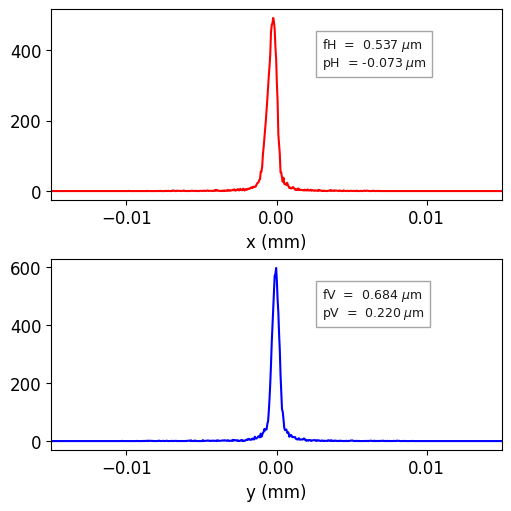

In [33]:
dwd = dict(ground_dw._DictionaryWrapper__dictionary)
print(dwd)
hist = ground_hist
xdata = hist.data_2D.sum(axis=0)
ydata = hist.data_2D.sum(axis=1)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
axs[0].plot(hist.hh, xdata, color='red')
axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)


axs[1].plot(hist.vv, ydata, color='blue')
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



text1 = (
    rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
)
axs[0].text(
    0.6,
    0.7,
    text1,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[0].transAxes,
)

text2 = (
    rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
    
)

axs[1].text(
    0.6,
    0.7,
    text2,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[1].transAxes,
)
plt.savefig(f"{out_dir}/focussed.svg", bbox_inches="tight", dpi=600)
plt.show()

Trial number 0
Trial values: peak_distance 1.173e-02 fwhm 7.596e-04
Trial dw:
{'h_sigma': 0.0031631145271632816, 'h_fwhm': 0.0005371093750000458, 'h_centroid': -0.007256055044811407, 'h_peak': -0.007397460937500001, 'v_sigma': 0.0009300646009543813, 'v_fwhm': 0.0005371093750000458, 'v_centroid': -0.009125162154994048, 'v_peak': 0.0091064453125, 'integral_intensity': 8342.158775600503, 'peak_intensity': 33.627622207106214, 'gaussian_fit': {}}
Actual fwhm 0.0007595873626028013


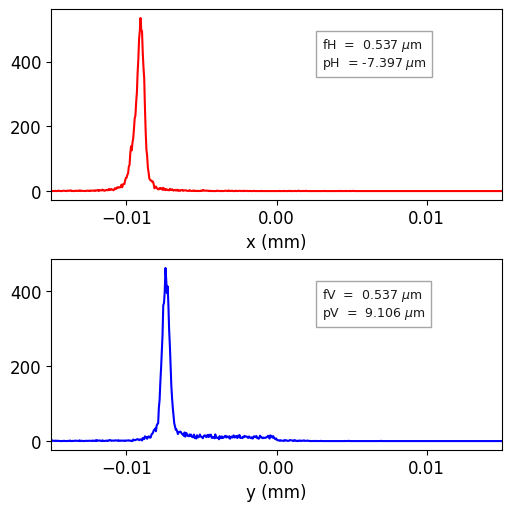

In [34]:
t = study.trials[0]
print("Trial number", t.number)
print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
print("Trial dw:")

dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
print(dwd)
print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
hist = hists[t.number]
xdata = hist.data_2D.sum(axis=0)
ydata = hist.data_2D.sum(axis=1)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
axs[0].plot(hist.hh, xdata, color='red')
axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)


axs[1].plot(hist.vv, ydata, color='blue')
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



text1 = (
    rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
)
axs[0].text(
    0.6,
    0.7,
    text1,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[0].transAxes,
)

text2 = (
    rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
    
)

axs[1].text(
    0.6,
    0.7,
    text2,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[1].transAxes,
)
plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
plt.show()

In [35]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [36]:
n_doms

[91, 75, 75, 83, 54, 85]

Trial number 75
Trial values: peak_distance 1.589e-03 fwhm 7.324e-04
Trial dw:
{'h_sigma': 0.0008760347980272993, 'h_fwhm': 0.00058593750000005, 'h_centroid': 5.8842502530722605e-05, 'h_peak': 7.324218750000104e-05, 'v_sigma': 0.0010136879883969603, 'v_fwhm': 0.00043945312500003747, 'v_centroid': -0.0021194171201777147, 'v_peak': 0.0015869140625, 'integral_intensity': 8335.220988125711, 'peak_intensity': 38.25646380273663, 'gaussian_fit': {}}
{'h_sigma': 0.0008760347980272993, 'h_fwhm': 0.00058593750000005, 'h_centroid': 5.8842502530722605e-05, 'h_peak': 7.324218750000104e-05, 'v_sigma': 0.0010136879883969603, 'v_fwhm': 0.00043945312500003747, 'v_centroid': -0.0021194171201777147, 'v_peak': 0.0015869140625, 'integral_intensity': 8335.220988125711, 'peak_intensity': 38.25646380273663, 'gaussian_fit': {}}
Actual fwhm 0.0007324218750000625


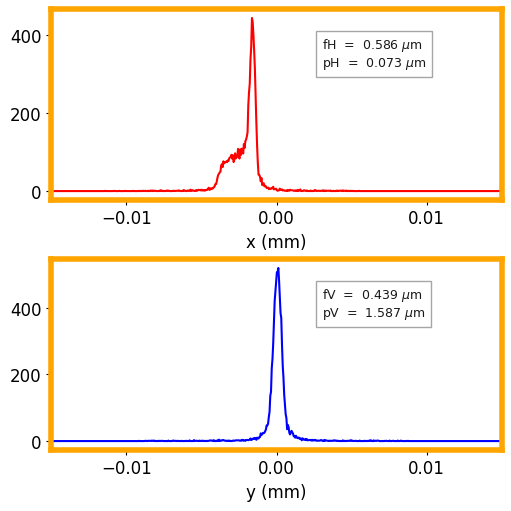

Trial number 79
Trial values: peak_distance 2.045e-03 fwhm 6.641e-04
Trial dw:
{'h_sigma': 0.0008661193978556026, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0018075581741417988, 'h_peak': 0.001879882812499999, 'v_sigma': 0.0009806468121039997, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.0003177518998347263, 'v_peak': -0.000805664062500001, 'integral_intensity': 8336.182782437752, 'peak_intensity': 35.997979377479815, 'gaussian_fit': {}}
{'h_sigma': 0.0008661193978556026, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0018075581741417988, 'h_peak': 0.001879882812499999, 'v_sigma': 0.0009806468121039997, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.0003177518998347263, 'v_peak': -0.000805664062500001, 'integral_intensity': 8336.182782437752, 'peak_intensity': 35.997979377479815, 'gaussian_fit': {}}
Actual fwhm 0.0006641343021844044


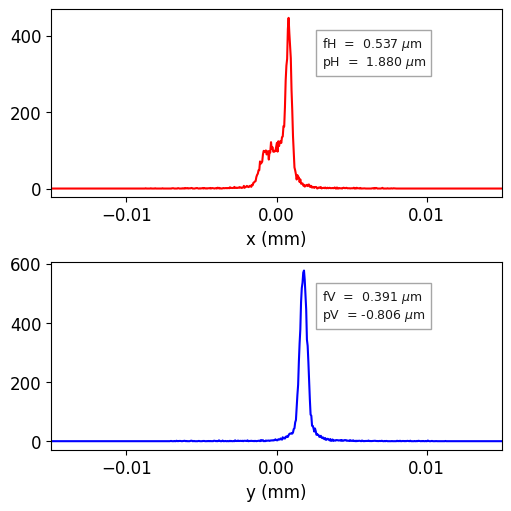

Trial number 88
Trial values: peak_distance 1.347e-03 fwhm 1.005e-03
Trial dw:
{'h_sigma': 0.0009756026468559656, 'h_fwhm': 0.0008789062500000749, 'h_centroid': 0.001172311548127087, 'h_peak': 0.0012451171875000003, 'v_sigma': 0.0008224343135251782, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -0.0005153454462135955, 'v_peak': 0.0005126953125000003, 'integral_intensity': 8340.099240947739, 'peak_intensity': 34.88791421380573, 'gaussian_fit': {}}
{'h_sigma': 0.0009756026468559656, 'h_fwhm': 0.0008789062500000749, 'h_centroid': 0.001172311548127087, 'h_peak': 0.0012451171875000003, 'v_sigma': 0.0008224343135251782, 'v_fwhm': 0.0004882812500000416, 'v_centroid': -0.0005153454462135955, 'v_peak': 0.0005126953125000003, 'integral_intensity': 8340.099240947739, 'peak_intensity': 34.88791421380573, 'gaussian_fit': {}}
Actual fwhm 0.0010054326309558476


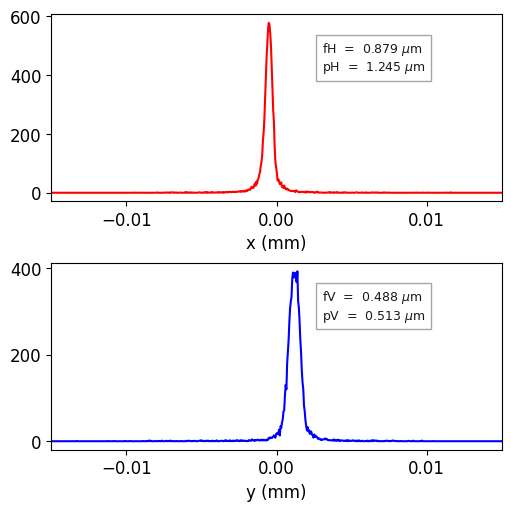

Trial number 114
Trial values: peak_distance 4.645e-04 fwhm 1.007e-03
Trial dw:
{'h_sigma': 0.001023576935770816, 'h_fwhm': 0.0006347656250000541, 'h_centroid': 0.0001271030982094878, 'h_peak': 2.4414062500000347e-05, 'v_sigma': 0.0009134196768585151, 'v_fwhm': 0.0007812500000000666, 'v_centroid': -0.0007331637546285928, 'v_peak': 0.00046386718749999965, 'integral_intensity': 8340.859778399152, 'peak_intensity': 24.646215608071127, 'gaussian_fit': {}}
{'h_sigma': 0.001023576935770816, 'h_fwhm': 0.0006347656250000541, 'h_centroid': 0.0001271030982094878, 'h_peak': 2.4414062500000347e-05, 'v_sigma': 0.0009134196768585151, 'v_fwhm': 0.0007812500000000666, 'v_centroid': -0.0007331637546285928, 'v_peak': 0.00046386718749999965, 'integral_intensity': 8340.859778399152, 'peak_intensity': 24.646215608071127, 'gaussian_fit': {}}
Actual fwhm 0.0010066175843793975


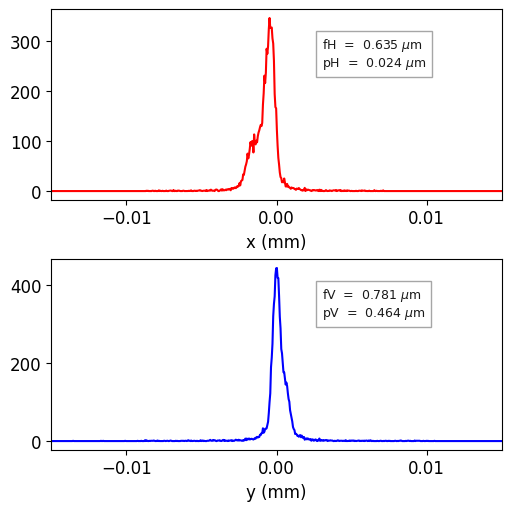

Trial number 117
Trial values: peak_distance 3.257e-04 fwhm 1.315e-03
Trial dw:
{'h_sigma': 0.0010782352246276594, 'h_fwhm': 0.0011230468750000958, 'h_centroid': -5.906605841327078e-05, 'h_peak': -0.00031738281250000104, 'v_sigma': 0.0010674101170579369, 'v_fwhm': 0.0006835937500000583, 'v_centroid': 0.0001979506582826155, 'v_peak': 7.324218750000104e-05, 'integral_intensity': 8342.283860645535, 'peak_intensity': 22.9741705662013, 'gaussian_fit': {}}
{'h_sigma': 0.0010782352246276594, 'h_fwhm': 0.0011230468750000958, 'h_centroid': -5.906605841327078e-05, 'h_peak': -0.00031738281250000104, 'v_sigma': 0.0010674101170579369, 'v_fwhm': 0.0006835937500000583, 'v_centroid': 0.0001979506582826155, 'v_peak': 7.324218750000104e-05, 'integral_intensity': 8342.283860645535, 'peak_intensity': 22.9741705662013, 'gaussian_fit': {}}
Actual fwhm 0.0013147375017419343


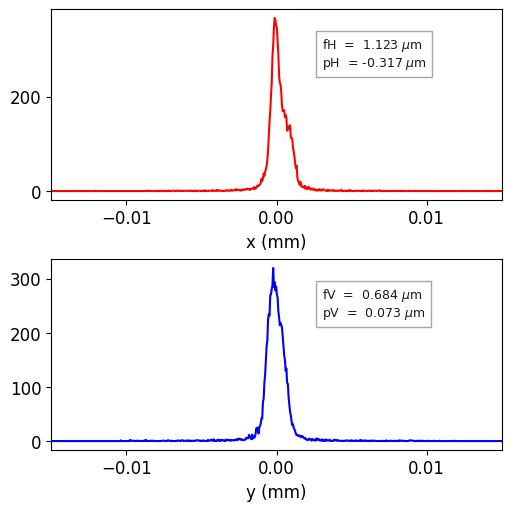

Trial number 122
Trial values: peak_distance 1.465e-03 fwhm 8.735e-04
Trial dw:
{'h_sigma': 0.0009766959948466982, 'h_fwhm': 0.0007812500000000666, 'h_centroid': -0.00021140373498366804, 'h_peak': -0.00026855468750000035, 'v_sigma': 0.001209462387487321, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.0008297906723782967, 'v_peak': -0.0014404296874999997, 'integral_intensity': 8337.737539877922, 'peak_intensity': 29.14413503148258, 'gaussian_fit': {}}
{'h_sigma': 0.0009766959948466982, 'h_fwhm': 0.0007812500000000666, 'h_centroid': -0.00021140373498366804, 'h_peak': -0.00026855468750000035, 'v_sigma': 0.001209462387487321, 'v_fwhm': 0.0003906250000000333, 'v_centroid': 0.0008297906723782967, 'v_peak': -0.0014404296874999997, 'integral_intensity': 8337.737539877922, 'peak_intensity': 29.14413503148258, 'gaussian_fit': {}}
Actual fwhm 0.0008734640537109298


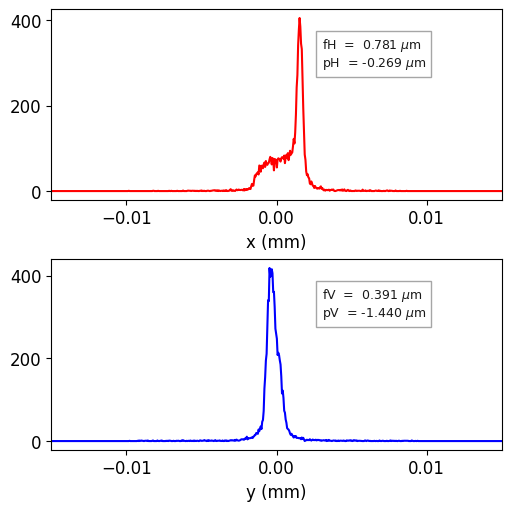

In [37]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")

    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dwd)

    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dwd)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    xdata = hist.data_2D.sum(axis=0)
    ydata = hist.data_2D.sum(axis=1)
    
    fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
    axs[0].plot(hist.hh, xdata, color='red')
    axs[0].set_xlim(-0.015, 0.015)
    axs[0].set_xlabel(r'x (mm)')
    axs[0].locator_params(nbins=4)
    
    
    axs[1].plot(hist.vv, ydata, color='blue')
    axs[1].set_xlim(-0.015, 0.015)
    axs[1].set_xlabel(r'y (mm)')
    
    axs[1].locator_params(nbins=4)
    
    
    
    text1 = (
        rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
        rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
    )
    axs[0].text(
        0.6,
        0.7,
        text1,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        transform=axs[0].transAxes,
    )
    
    text2 = (
        rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
        rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
        
    )
    
    axs[1].text(
        0.6,
        0.7,
        text2,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
        transform=axs[1].transAxes,
    )
    plt.savefig(f"{out_dir}/pareto_{t.number}.svg", bbox_inches="tight", dpi=600)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            axs[0].spines[axis].set_linewidth(4)
            axs[0].spines[axis].set_color("orange")
            axs[1].spines[axis].set_linewidth(4)
            axs[1].spines[axis].set_color("orange")
    plt.show()

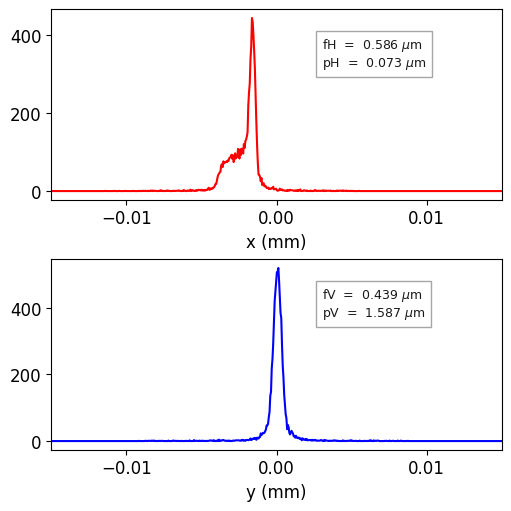

In [38]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]

xdata = hist.data_2D.sum(axis=0)
ydata = hist.data_2D.sum(axis=1)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)
axs[0].plot(hist.hh, xdata, color='red')
axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)


axs[1].plot(hist.vv, ydata, color='blue')
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



text1 = (
    rf"{'fH':<3} = {dwd['h_fwhm'] * 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pH':<3} = {dwd['h_peak']* 1000: 4.3f} $\mu$m"
)
axs[0].text(
    0.6,
    0.7,
    text1,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[0].transAxes,
)

text2 = (
    rf"{'fV':<3} = {dwd['v_fwhm']* 1000: 4.3f} $\mu$m" + "\n"
    rf"{'pV':<3} = {dwd['v_peak']* 1000: 4.3f} $\mu$m"
    
)

axs[1].text(
    0.6,
    0.7,
    text2,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=axs[1].transAxes,
)
plt.savefig(f"{out_dir}/pareto_hh.svg", bbox_inches="tight", dpi=600)
plt.show()

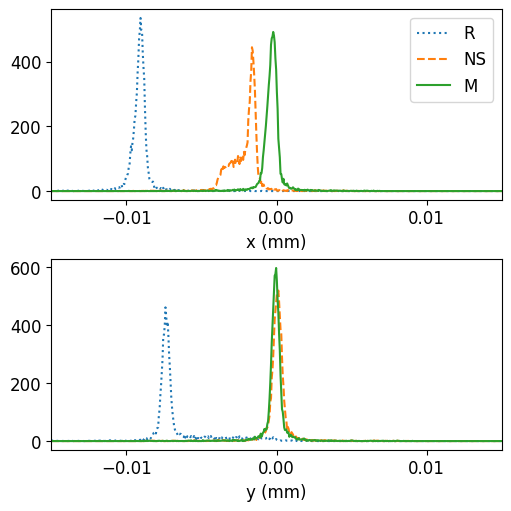

In [39]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]

xdata = hist.data_2D.sum(axis=0)
ydata = hist.data_2D.sum(axis=1)

hist2 = hists[0]
xdata2 = hist2.data_2D.sum(axis=0)
ydata2 = hist2.data_2D.sum(axis=1)

hist3 = ground_hist
xdata3 = hist3.data_2D.sum(axis=0)
ydata3 = hist3.data_2D.sum(axis=1)

fig, axs = plt.subplots(2, 1, figsize=[5, 5], constrained_layout=True)

axs[0].plot(hist2.hh, xdata2,  label='R', ls=':')
axs[0].plot(hist.hh, xdata,  label='NS', ls='--')
axs[0].plot(hist3.hh, xdata3, label='M', ls='-',)

axs[0].set_xlim(-0.015, 0.015)
axs[0].set_xlabel(r'x (mm)')
axs[0].locator_params(nbins=4)
axs[0].legend(loc='best')


axs[1].plot(hist2.vv, ydata2,  label='R', ls=':')
axs[1].plot(hist.vv, ydata,  label='NS', ls='--')
axs[1].plot(hist3.vv, ydata3,  label='M', ls='-')

axs[1].set_xlim(-0.015, 0.015)
axs[1].set_xlabel(r'y (mm)')

axs[1].locator_params(nbins=4)



plt.show()

In [40]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [41]:
c2

[79, 88, 114, 117, 122]

In [42]:
def get_y_values(study, val_index):
    y = []
    for t in study.trials:
        if t.values is None:
            y.append(np.nan)
        else:
            y.append(t.values[val_index])
    return np.array(y)
    

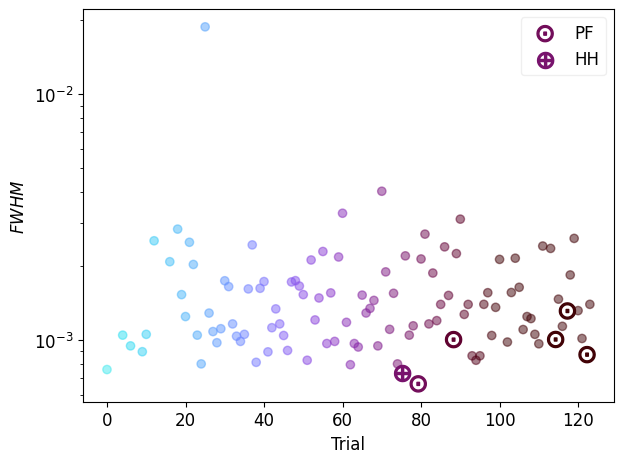

In [43]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = get_y_values(study, 0)

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="HH"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

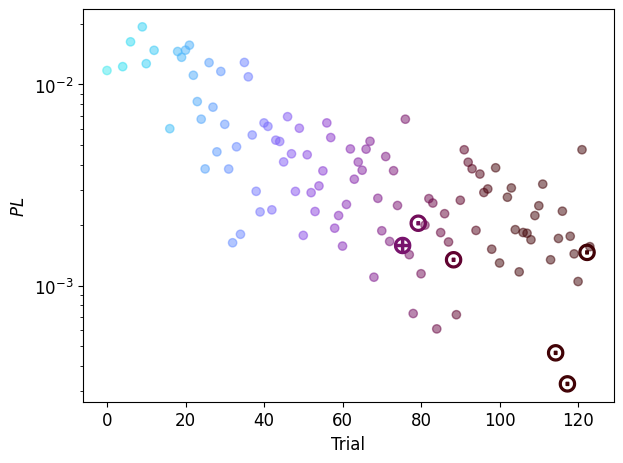

In [44]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = get_y_values(study, 1)

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$PL$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

In [45]:
ground

{'FWHM': 0.0008693600495491393, 'PL': 0.0002316121333131137}

In [46]:
out_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/34idc_sim_peak_fwhm_one_step/noise_free')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_25993/3171880659.py:29: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.462583681393228 4.352882222222223


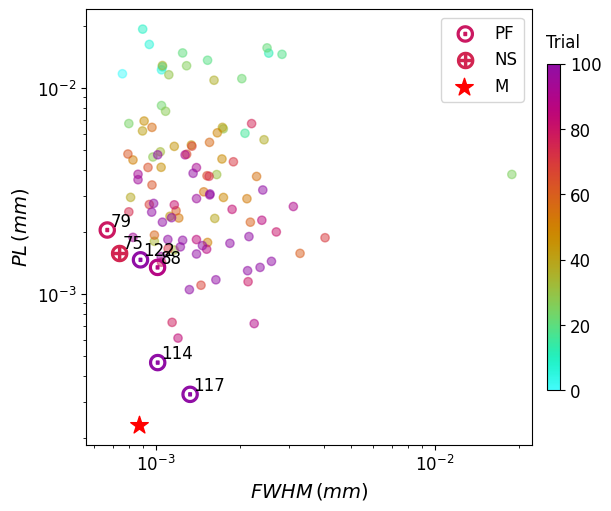

In [47]:
x = get_y_values(study, 0)
y = get_y_values(study, 1)

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$PL\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

plt.scatter(ground["FWHM"], ground["PL"], color="red", marker="*", s=175, label="M")
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [48]:
nash_idx, nash_trial.number

(0, 75)

In [49]:
ground

{'FWHM': 0.0008693600495491393, 'PL': 0.0002316121333131137}

In [50]:
props = apu.AnalyzedProps(study, nash_trial, max_count=maxcount, min_count=0, xylim=0.009, distance_units='um', float_format='4.2f', hist_nlpi_text=False)

In [51]:
markers = [".", 'o', 'D',  's', 'P', 'X', '<','>','^','v', '1', '2']
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
lst = [t[1] for t in linestyle_tuple]

#prop_cycler = cycler(marker=markers) + cycler(ls=lst) #+ cycler(color=colors)
prop_cycler = cycler(ls=lst)



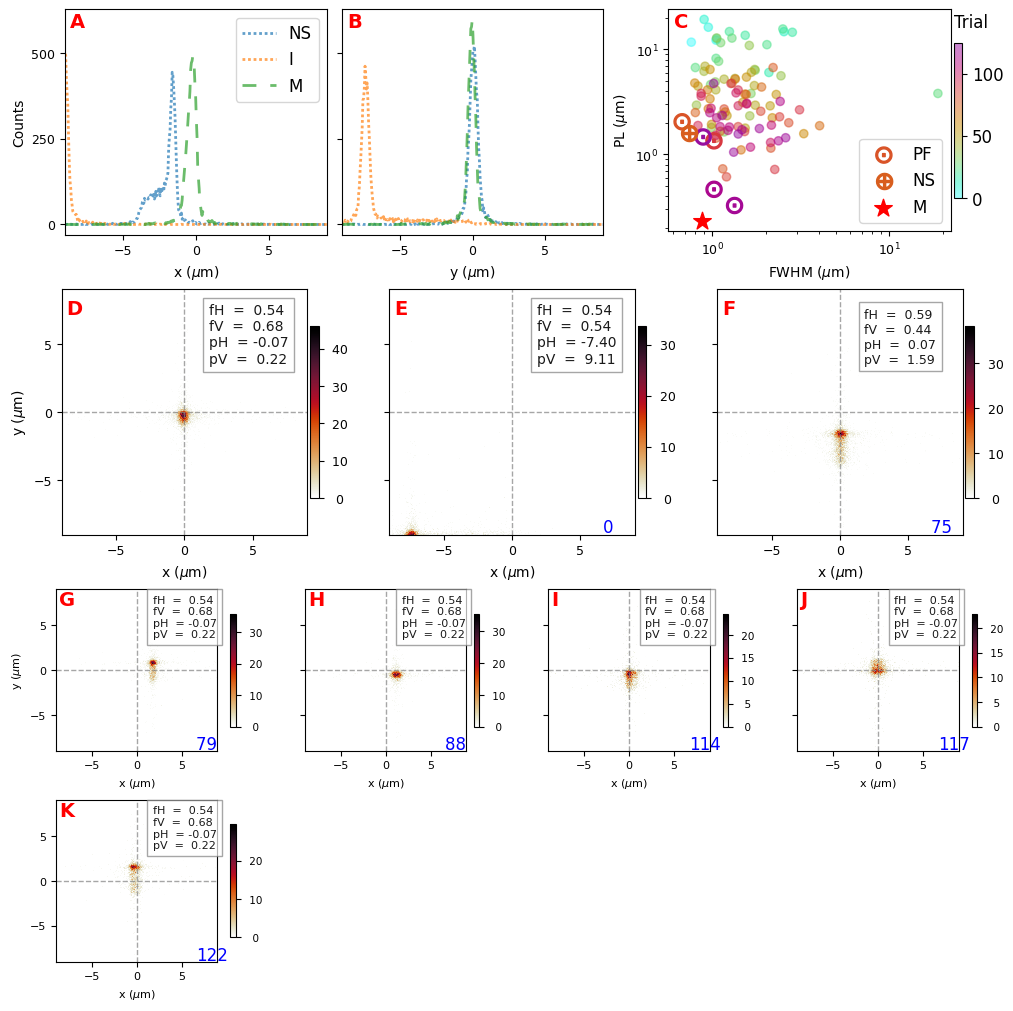

In [60]:
fig = plt.figure(figsize=[10, 10], layout="constrained")
#gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.44, 0.21, 0.35])
gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.28, 0.3, 0.42])

# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], width_ratios=[0.6,0.4])
gss00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gss0[0])

axs0 = gss00.subplots(sharey=True)

pc = prop_cycler()
sublabel = apu.plot_1d_lines(props, axs0[0], hists[nash_trial.number], hist_ground=ground_hist, hist_init=hists[0], label='NS', 
                             cyc=pc, sublabel='A', labelfontsize=10, ticklabelsize=9)

#for ix, t in enumerate(study.best_trials):
#    if t.number == nash_trial.number: continue
#    apu.plot_1d_lines(axs0[0], hists[t.number], label=f'PF{t.number}', cyc=pc, labelfontsize=10)

#axs0[0].set_xlim(-0.009, 0.009)
axs0[0].locator_params(nbins=3)
axs0[0].legend(loc='best')
axs0[0].set_ylabel('Counts', fontsize=10)


pc = prop_cycler()
sublabel = apu.plot_1d_lines(props, axs0[1], hists[nash_trial.number], hist_ground=ground_hist, hist_init=hists[0], label='NS', cyc=pc, axis=1,
                            sublabel=sublabel, labelfontsize=10)

#for ix, t in enumerate(study.best_trials):
#    if t.number == nash_trial.number: continue
#    apu.plot_1d_lines(axs0[1], hists[t.number], label=f'PF{t.number}', cyc=pc, axis=1, labelfontsize=10)

#axs0[1].set_xlim(-0.009, 0.009)
axs0[1].locator_params(nbins=3)


gss01 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gss0[1])
axs01 = gss01.subplots()
cscatter, sublabel = apu.plot_pareto_2d(
    props, axs01, "FWHM", "PL", sublabel=sublabel, ground=ground, annotate=False, legend=True, fontsize=10, ticklabelsize=9
)
#_, sublabel = apu.plot_pareto_2d(props, axs2[1], "FWHM", "NLPI", sublabel=sublabel, ground=ground)
#_, sublabel = apu.plot_pareto_2d(props, axs2[2], "PL", "NLPI", sublabel=sublabel, ground=ground)

cbar = plt.colorbar(cscatter, ax=axs01, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 1.1, "Trial", transform=cbar.ax.transAxes)



# middle row
gss1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1])
axs1 = gss1.subplots(sharey=True)

cmesh, sublabel = apu.plot_hist_2d(props, axs1[0], ground_hist, ylabel=True, ticklabelsize=9, sublabel=sublabel, labelfontsize=10)
apu.add_text_to_hist(props, axs1[0], ground_dw, fontsize=10)

cmesh0, sublabel = apu.plot_hist_2d(props, axs1[1], hists[0], study_num=0, sublabel=sublabel, ticklabelsize=9, labelfontsize=10)
apu.add_text_to_hist(props, axs1[1], study.trials[0].user_attrs["dw"], fontsize=10)

cmesh1, sublabel = apu.plot_hist_2d(props, axs1[2], hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel, 
                                    ticklabelsize=9, labelfontsize=10)
apu.add_text_to_hist(props, axs1[2], study.trials[nash_trial.number].user_attrs["dw"], fontsize=9)
# _, sublabel = apu.

for ix, cmesh in enumerate([cmesh, cmesh0, cmesh1]):
    cbar = fig.colorbar(cmesh, ax=axs1[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=9)
    axs1[ix].locator_params(nbins=4)


# bottom row

gss2 = gridspec.GridSpecFromSubplotSpec(np.ceil((len(study.best_trials) - 1)/ 4).astype('int'), 4, subplot_spec=gs0[2])
axs2 = gss2.subplots(sharey=True)
axs2 = axs2.flatten()


_trials = [t for t in study.best_trials if t.number != nash_trial.number]

for ax in axs2:
    ax.axis('off')

for ix, t in enumerate(_trials):
    axs2[ix].axis('on')
    ylabel = True if ix == 0 else False
    cmesh, sublabel = apu.plot_hist_2d(props, axs2[ix], hists[t.number], ylabel=ylabel, ticklabelsize=8, 
                                       sublabel=sublabel, study_num=t.number, labelfontsize=8)
    apu.add_text_to_hist(props, axs2[ix], ground_dw, fontsize=8)

    cbar = fig.colorbar(cmesh, ax=axs2[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=7.5)
    axs2[ix].locator_params(nbins=3)

plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.show()